In [1]:
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


import folium

In [2]:
plt.style.use('images/presentation.mplstyle')

In [3]:
crashes = pd.read_pickle('data/crashes.pkl')
crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300067 entries, 0 to 526552
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          300067 non-null  object 
 1   CRASH_YEAR               300067 non-null  int64  
 2   POSTED_SPEED_LIMIT       300067 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   292808 non-null  object 
 4   DEVICE_CONDITION         286326 non-null  object 
 5   WEATHER_CONDITION        293434 non-null  object 
 6   LIGHTING_CONDITION       296512 non-null  object 
 7   FIRST_CRASH_TYPE         300067 non-null  object 
 8   TRAFFICWAY_TYPE          289966 non-null  object 
 9   ALIGNMENT                300067 non-null  object 
 10  ROADWAY_SURFACE_COND     287717 non-null  object 
 11  ROAD_DEFECT              261922 non-null  object 
 12  CRASH_TYPE               300067 non-null  object 
 13  INTERSECTION_RELATED_I   84862 non-null   object 
 14  HIT_

In [4]:
crashes_map = crashes[['LATITUDE',
                       'LONGITUDE',
                       'MOST_SEVERE_INJURY',
                       'INJURIES_TOTAL',
                       'INJURIES_FATAL'
                      ]].copy().dropna()
mask = (crashes_map['LATITUDE'] != 0) & (crashes_map['LONGITUDE'] != 0)
crashes_map = crashes_map[mask]

In [5]:
mask = ((crashes_map['MOST_SEVERE_INJURY'] == 'NONINCAPACITATING INJURY')
        | (crashes_map['MOST_SEVERE_INJURY'] == 'INCAPACITATING INJURY')
        | (crashes_map['MOST_SEVERE_INJURY'] == 'FATAL'))

crashes_injuries_map = crashes_map[mask]
crashes_injuries_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32815 entries, 7 to 526544
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LATITUDE            32815 non-null  float64
 1   LONGITUDE           32815 non-null  float64
 2   MOST_SEVERE_INJURY  32815 non-null  object 
 3   INJURIES_TOTAL      32815 non-null  float64
 4   INJURIES_FATAL      32815 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.5+ MB


In [6]:
crashes_injuries_map.MOST_SEVERE_INJURY.value_counts(dropna=False)

NONINCAPACITATING INJURY    26501
INCAPACITATING INJURY        5996
FATAL                         318
Name: MOST_SEVERE_INJURY, dtype: int64

## Choropleth Map - Injuries by Zipcode

In [7]:
average_lat, average_long = crashes_injuries_map[['LATITUDE', 'LONGITUDE']].mean()
print(f"Average Latitude: {average_lat}")
print(f"Average Longitude: {average_long}")

Average Latitude: 41.850618430459384
Average Longitude: -87.67619919169346


In [8]:
import googlemaps
import time
with open('.secrets/gmaps.json') as f:
    key = json.load(f)
GMAPS = googlemaps.Client(**key)

In [9]:
# Collect ZIP code from Google Maps API using coordinates
def get_zipcode(lat, long):
    result = GMAPS.reverse_geocode((lat, long), 'postal_code')
    try:
        zipcode = int(result[0]['address_components'][0]['long_name'])
    except:
        zipcode = 0
    return zipcode

```
    # THIS TAKES A LONG TIME. Un-Markdown this cell to reload the zipcodes
    zipcodes = np.zeros(crashes_injuries_map.shape[0])
    for i in range(crashes_injuries_map.shape[0]):
        lat, long = crashes_injuries_map[['LATITUDE', 'LONGITUDE']].iloc[i]
        zipcode = get_zipcode(lat, long)
        zipcodes[i] = zipcode
        
        # Mark progress
        if i % 1000==0:
            print('*', end='')
    
    crashes_injuries_map['ZIPCODE'] = zipcodes
    crashes_injuries_map['ZIPCODE'] = crashes_injuries_map['ZIPCODE'].astype(int).astype(str)
    
    # Pickle Data
    with open('data/crashes_injuries_map.pkl', 'wb') as f:
        pickle.dump(crashes_injuries_map, f)
```

In [10]:
with open('data/crashes_injuries_map.pkl', 'rb') as f:
    injuries_by_zip = pickle.load(f)

In [11]:
zipcodes_grouped = injuries_by_zip.groupby('ZIPCODE').sum().reset_index()

In [12]:
# Load GeoJson file
with open('data/chicago_zipcodes.geojson') as f:
    chicago_zipcodes = json.load(f)

In [13]:
# Preview GeoJson structure
chicago_zipcodes['features'][0]['properties']

{'objectid': '33',
 'shape_area': '106052287.488',
 'shape_len': '42720.0444058',
 'zip': '60647'}

### Tile Choices
```
“OpenStreetMap”
“Mapbox Bright” (Limited levels of zoom for free tiles)
“Mapbox Control Room” (Limited levels of zoom for free tiles)
“Stamen” (Terrain, Toner, and Watercolor)
“Cloudmade” (Must pass API key)
“Mapbox” (Must pass API key)
“CartoDB” (positron and dark_matter)
```

In [34]:
m_total = folium.Map(
    location=[average_lat, average_long],
    width='75%',
    length='75%',
    zoom_start=10,
    tiles='OpenStreetMap',
    zoom_control=False
)

choropleth = folium.Choropleth(
    geo_data=chicago_zipcodes,
    data=zipcodes_grouped,
    columns=['ZIPCODE', 'INJURIES_TOTAL'],
    key_on='feature.properties.zip',
    nan_fill_color=None,
    fill_color="GnBu",
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Total Number of Injuries' 
    
)

choropleth.add_to(m_total)

In [35]:
m_total

In [16]:
m_fatal = folium.Map(
    location=[average_lat, average_long],
    width='75%',
    length='75%',
    zoom_start=10,
    tiles='OpenStreetMap',
    zoom_control=False
)

choropleth = folium.Choropleth(
    geo_data=chicago_zipcodes,
    data=zipcodes_grouped,
    columns=['ZIPCODE', 'INJURIES_FATAL'],
    key_on='feature.properties.zip',
    nan_fill_color=None,
    fill_color="Reds",
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Total Number of Injuries' 
    
)

choropleth.add_to(m_fatal)

In [17]:
m_fatal

# Scatter Plot by Injury Severity

In [18]:
crashes_injuries_map.MOST_SEVERE_INJURY.value_counts(dropna=False)

NONINCAPACITATING INJURY    26501
INCAPACITATING INJURY        5996
FATAL                         318
Name: MOST_SEVERE_INJURY, dtype: int64

In [19]:
crashes_injuries_map.describe()

LATITUDE     LONGITUDE  INJURIES_TOTAL  INJURIES_FATAL
count  32815.000000  32815.000000    32815.000000    32815.000000
mean      41.850618    -87.676199        1.449947        0.010605
std        0.085311      0.059400        0.916013        0.112907
min       41.645823    -87.933994        1.000000        0.000000
25%       41.775290    -87.720592        1.000000        0.000000
50%       41.870982    -87.669872        1.000000        0.000000
75%       41.911857    -87.630802        2.000000        0.000000
max       42.022780    -87.524589       21.000000        4.000000

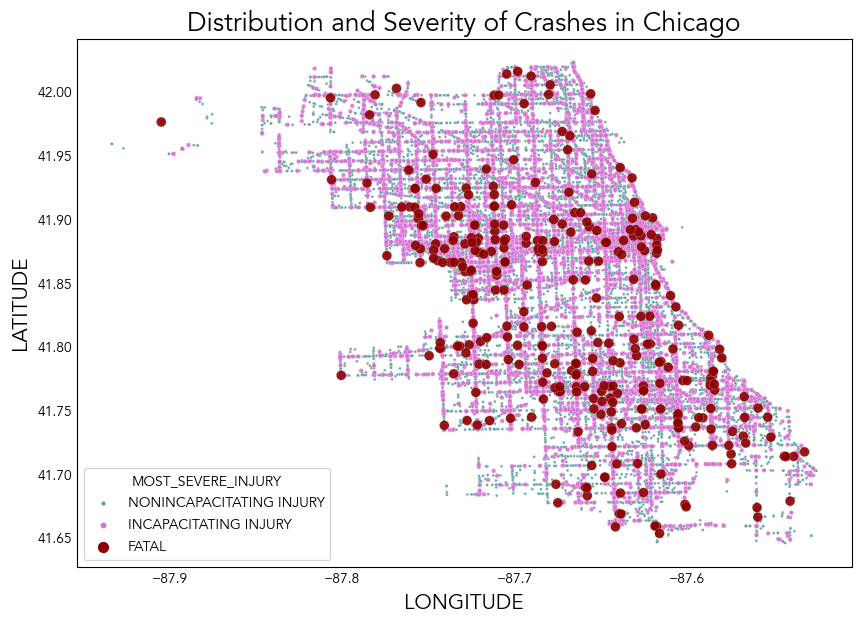

In [20]:
with plt.style.context('images/presentation.mplstyle'):
    colors = {
        'FATAL': 'darkred',
        'INCAPACITATING INJURY': 'orchid',
        'NONINCAPACITATING INJURY': 'cadetblue'
    }
    
    sizes = {
        'NONINCAPACITATING INJURY': 4,
        'INCAPACITATING INJURY': 10,
        'FATAL': 50
    }
    fig, ax = plt.subplots()
    
    fig = sns.scatterplot(x='LONGITUDE',
                    y='LATITUDE',
                    hue='MOST_SEVERE_INJURY',
                    size='MOST_SEVERE_INJURY',
                    sizes=sizes,
                    palette=colors,
                    data=crashes_injuries_map.sort_values('MOST_SEVERE_INJURY', ascending=False),
                    alpha=0.9,
                    ax=ax
    )
    ax.set_title('Distribution and Severity of Crashes in Chicago')

    ax.tick_params(length=0)
    plt.savefig('images/crashes_scattermap_t.png', dpi=150, transparent=True)
    plt.savefig('images/crashes_scattermap.png', dpi=150,)

# Crashes by Year

In [21]:
with open('data/injuries_by_month.pkl', 'rb') as f:
    injuries_by_month = pickle.load(f)

injuries_by_year = injuries_by_month.groupby('CRASH_YEAR').sum().reset_index()

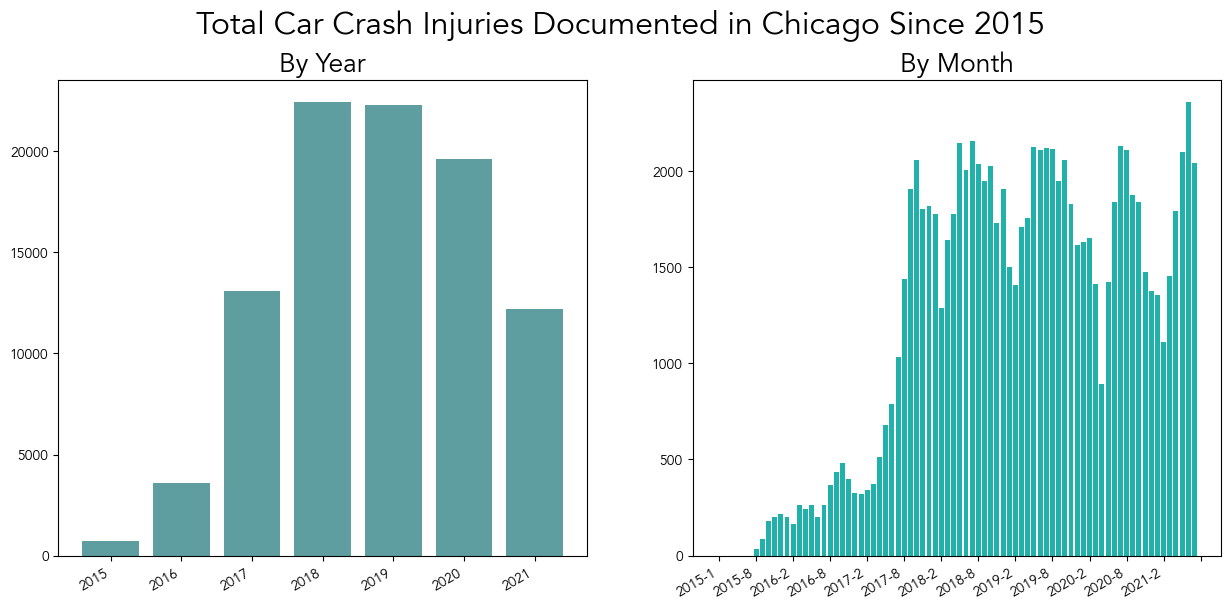

In [22]:
with plt.style.context('images/presentation.mplstyle'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    fig.suptitle('Total Car Crash Injuries Documented in Chicago Since 2015', fontsize=23, fontweight='bold')

    axes[0].bar('CRASH_YEAR', 'INJURIES_TOTAL', color='cadetblue', data=injuries_by_year)
    axes[0].set_title('By Year')
    axes[1].bar('YEAR_MONTH', 'INJURIES_TOTAL', color='lightseagreen', data=injuries_by_month)
    axes[1].set_title('By Month')
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(15))


    fig.autofmt_xdate()
    plt.savefig('images/total_injuries_time.png', dpi=150)

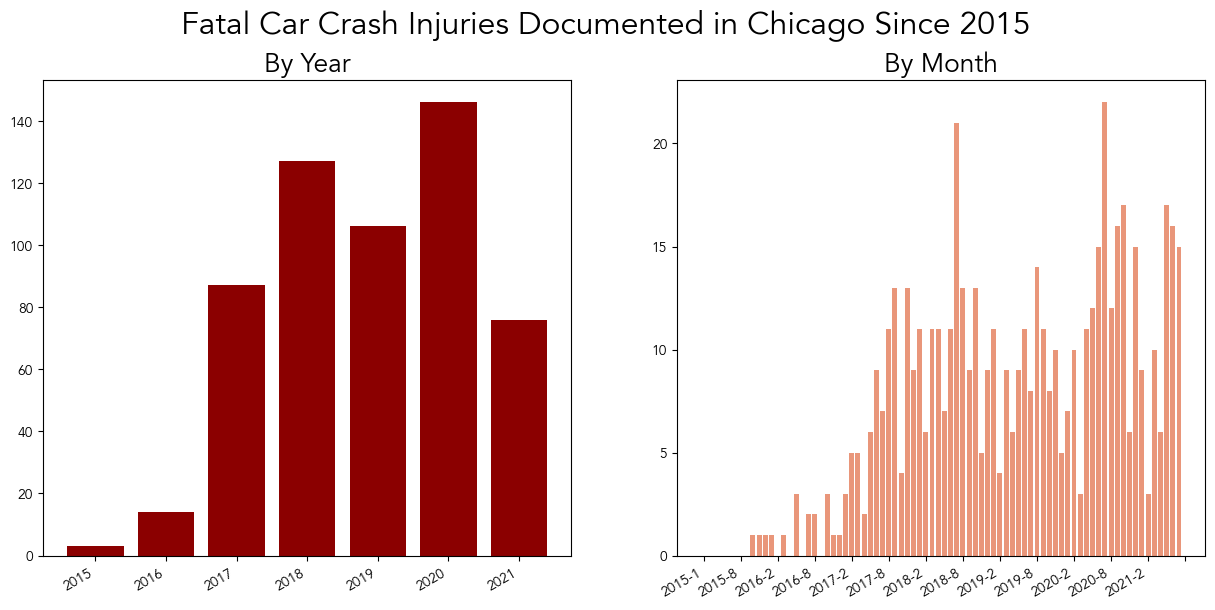

In [23]:
with plt.style.context('images/presentation.mplstyle'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    fig.suptitle('Fatal Car Crash Injuries Documented in Chicago Since 2015', fontsize=23, fontweight='bold')

    axes[0].bar('CRASH_YEAR', 'INJURIES_FATAL', color='darkred', data=injuries_by_year)
    axes[0].set_title('By Year')
    axes[1].bar('YEAR_MONTH', 'INJURIES_FATAL', color='darksalmon', data=injuries_by_month)
    axes[1].set_title('By Month')
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(15))


    fig.autofmt_xdate()
    plt.savefig('images/fatal_injuries_time.png', dpi=150)

## Primary Contributory Causes

In [24]:
with open('pipelines/binned_causes.pkl', 'rb') as f:
    binned_causes = pickle.load(f)

In [25]:
crashes_grouped = crashes.groupby('PRIM_CONTRIBUTORY_CAUSE')['CRASH_RECORD_ID'].count()\
.reset_index()\
.rename({'CRASH_RECORD_ID': 'COUNT'}, axis=1)\
.sort_values('COUNT', ascending=False)

In [26]:
text = '\n\n'.join([x.title() for x in crashes_grouped.PRIM_CONTRIBUTORY_CAUSE.values][0:10])

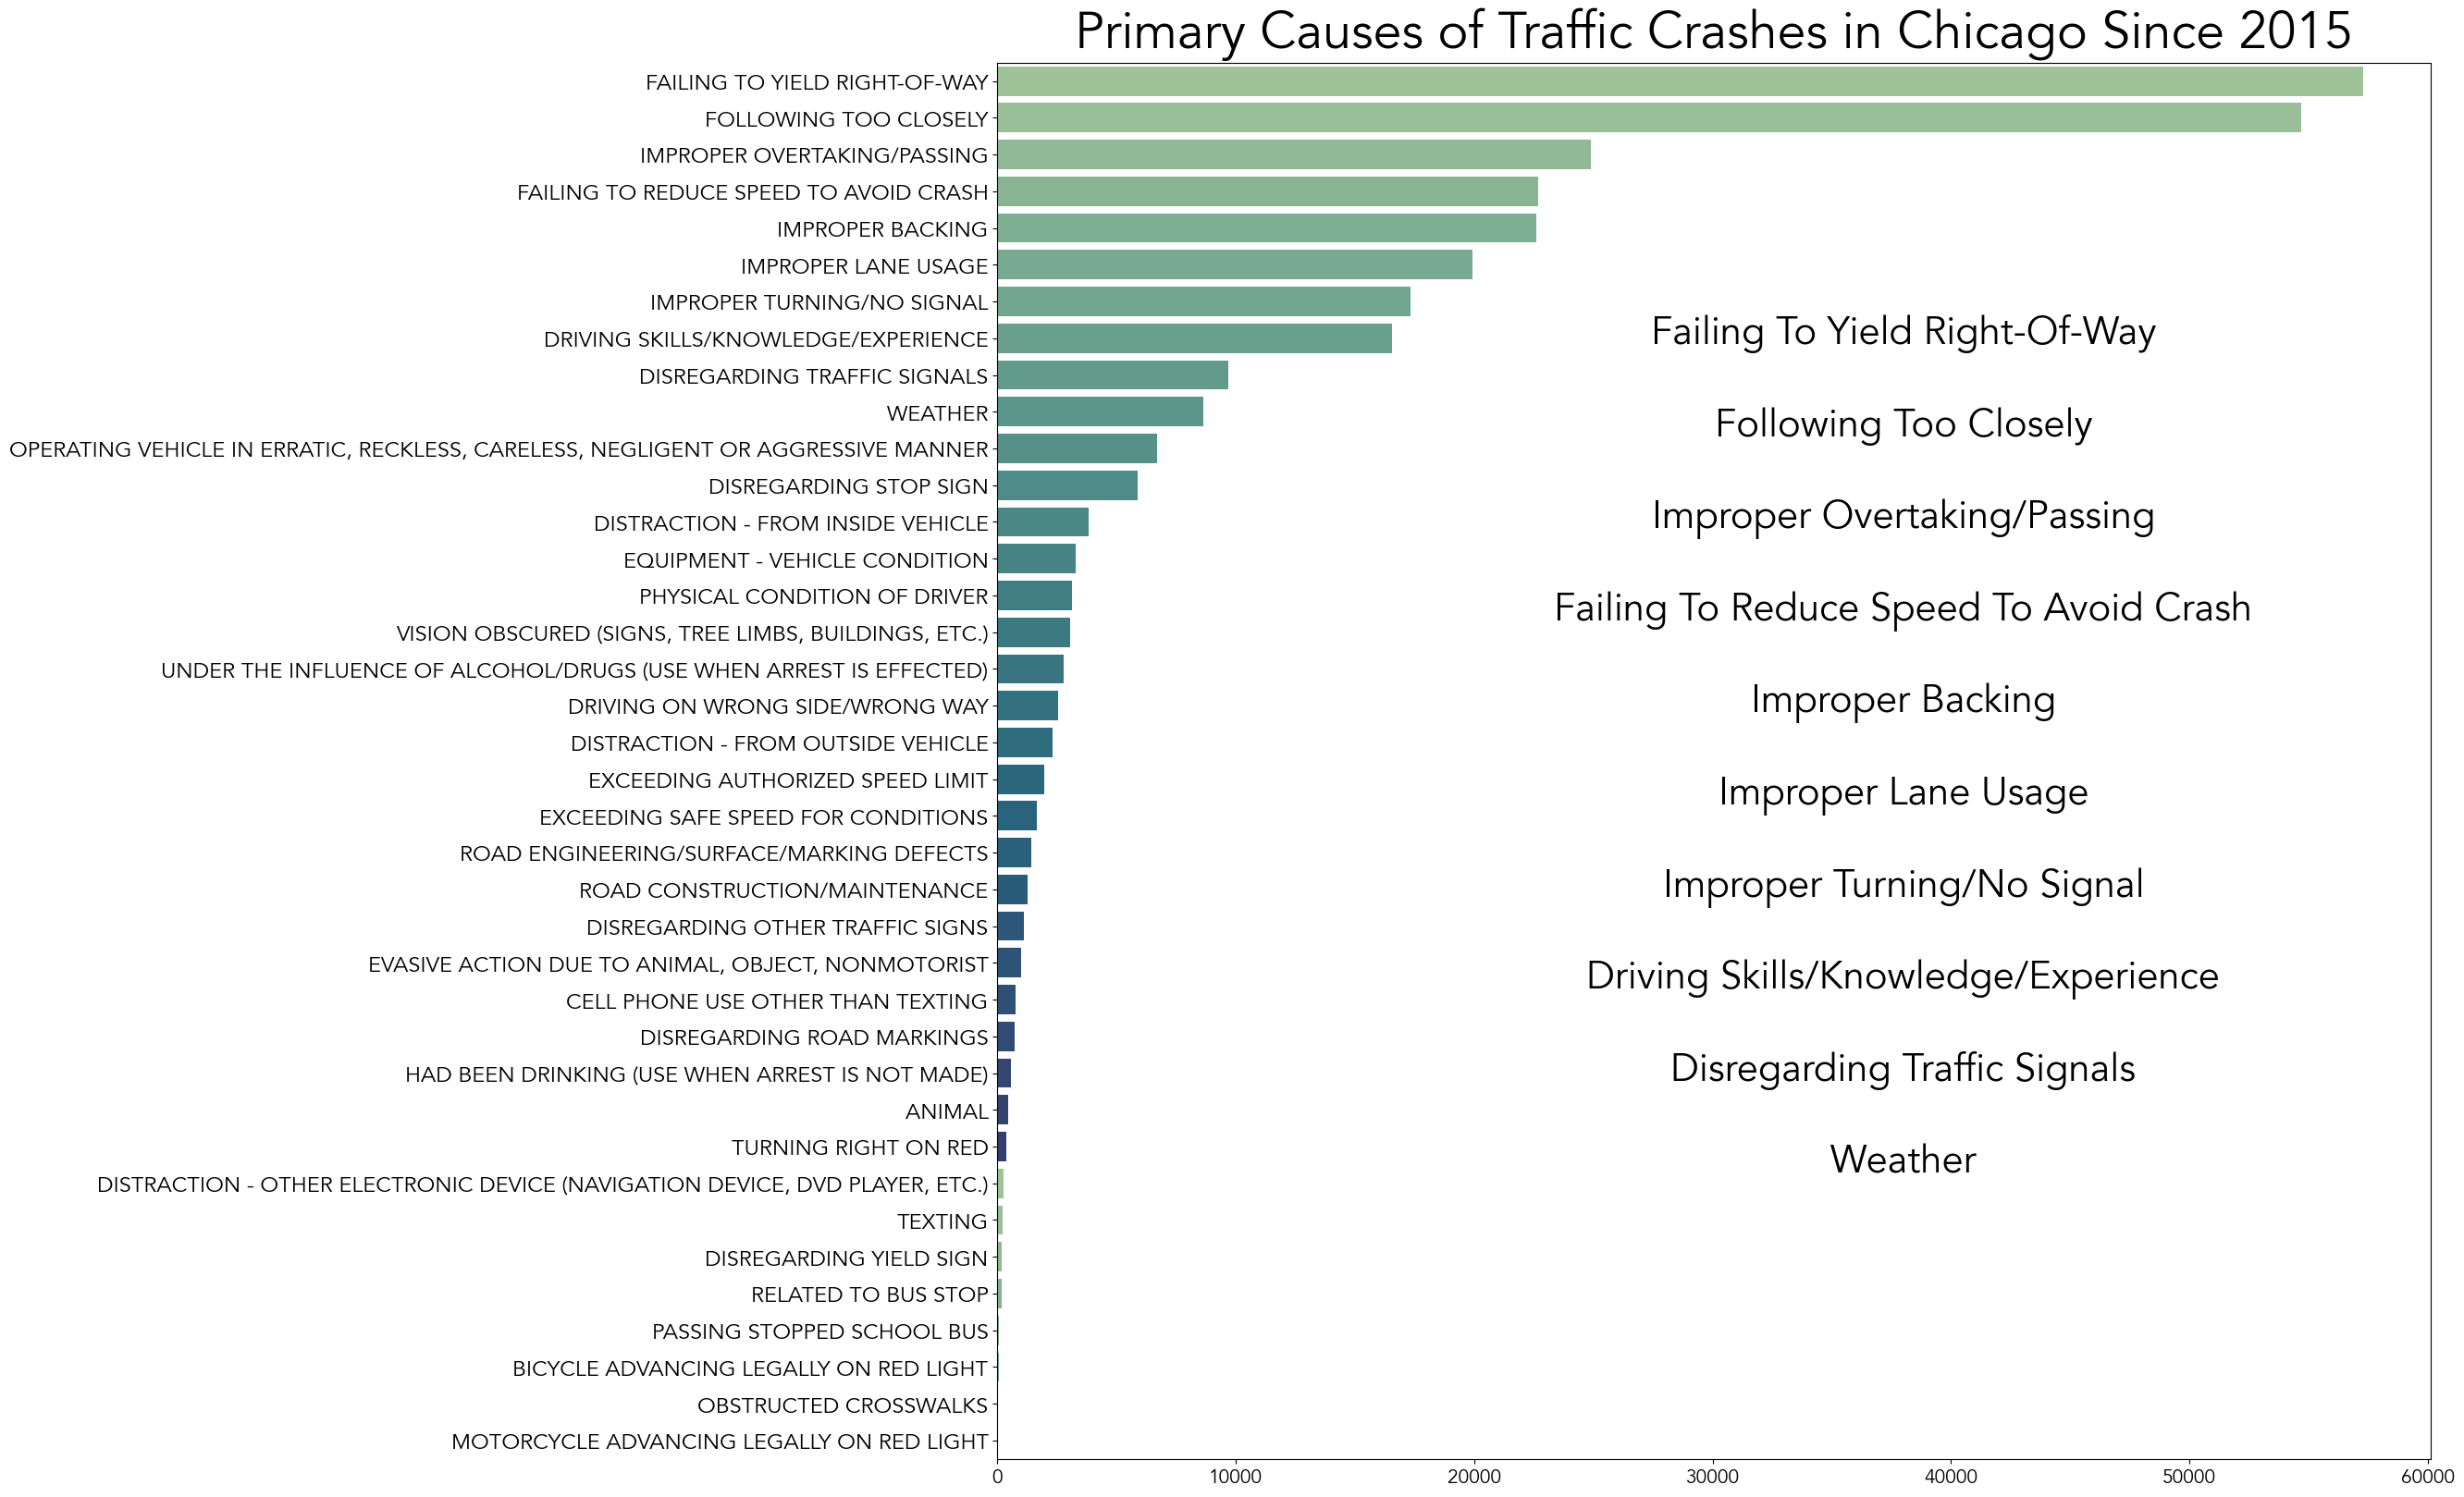

In [32]:
with plt.style.context('images/presentation.mplstyle'):
    
    palette = sns.color_palette('crest', n_colors=30)
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.barplot(data=crashes_grouped,
                y='PRIM_CONTRIBUTORY_CAUSE',
                x='COUNT',
                orient='h',
                ax=ax,
                palette = palette
               )
    
    ax.set_title('Primary Causes of Traffic Crashes in Chicago Since 2015', fontsize=40)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.tick_params(axis='y', labelsize=17)
    ax.tick_params(axis='x', labelsize=15)
    anno_opts = {
        'text': text,
        'xy': (38_000, 30),
        'va': 'bottom',
        'ha':'center',
        'fontsize': 30,
        'fontweight': 700
    }
    
    ax.annotate(**anno_opts)
    plt.savefig('images/primary_causes_large.png', dpi=200)

In [28]:
crashes_binned = crashes.copy()
crashes_binned['PRIM_CONTRIBUTORY_CAUSE'] = crashes_binned['PRIM_CONTRIBUTORY_CAUSE'].map(binned_causes)

crashes_binned_grouped = crashes_binned.groupby('PRIM_CONTRIBUTORY_CAUSE')['CRASH_RECORD_ID'].count()\
.reset_index()\
.rename({'CRASH_RECORD_ID': 'COUNT'}, axis=1)\
.sort_values('COUNT', ascending=False)

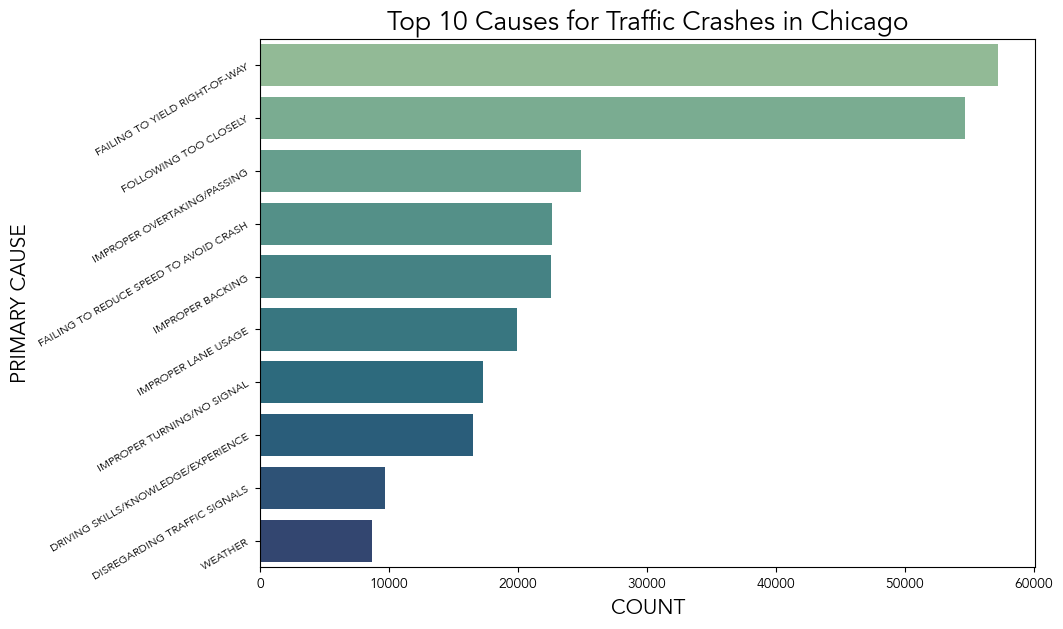

In [29]:
with plt.style.context('images/presentation.mplstyle'):
    fig, ax = plt.subplots()
    palette = sns.color_palette('crest', n_colors=10)
    
    sns.barplot(data=crashes_grouped[:10],
            y='PRIM_CONTRIBUTORY_CAUSE',
            x='COUNT',
            orient='h',
            palette=palette,
            ax=ax
           )
    ax.set_title('Top 10 Causes for Traffic Crashes in Chicago')
    ax.tick_params(axis='y', labelrotation=30, labelsize=8)
    ax.set_ylabel('PRIMARY CAUSE')
    
    plt.savefig('images/top_ten_causes.png', dpi=150)

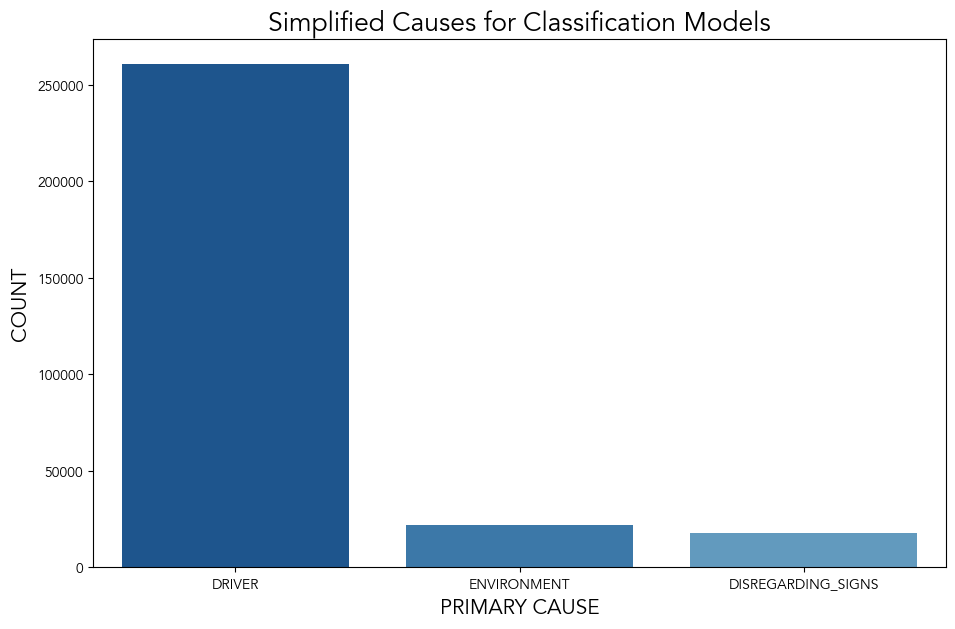

In [37]:
with plt.style.context('images/presentation.mplstyle'):
    fig, ax = plt.subplots(figsize=(11, 7))
    palette = sns.color_palette('Blues_r')
    
    sns.barplot(data=crashes_binned_grouped,
                x='PRIM_CONTRIBUTORY_CAUSE',
                y='COUNT',
                orient='v',
                palette = palette,
                ax=ax
               )
    ax.set_title('Simplified Causes for Classification Models')
    ax.set_xlabel('PRIMARY CAUSE')
    
    plt.savefig('images/binned_categories_bar.png', dpi=150)
    